![n7](http://cots.perso.enseeiht.fr/figures/inp-enseeiht.png)

# Transfert orbital en temps minimal

Ce sujet (ou TP-projet) est à rendre (voir la date sur moodle et les modalités du rendu) et sera évalué pour faire partie de la note finale de la matière Contrôle Optimal.

----

On considère le problème du transfert d'un satellite d'une orbite initiale à l'orbite géostationnaire à temps minimal. Ce problème s'écrit comme un problème de contrôle optimal sous la forme

$$
\left\lbrace
\begin{array}{l}
    \min J(x, u, t_f) = t_f \\[1.0em]
    \ \ \dot{x}_{1}(t) = ~ x_{3}(t)  \\
    \ \ \dot{x}_{2}(t) = ~ x_{4}(t)  \\
    \ \ \dot{x}_{3}(t) =  -\dfrac{\mu\, x_{1}(t)}{r^{3}(t)} + u_{1}(t)  \\
    \ \ \dot{x}_{4}(t) =  -\dfrac{\mu\, x_{2}(t)}{r^{3}(t)}+u_{2}(t), ~~ ||u(t)|| \leq \gamma_\mathrm{max}, ~~ t \in [0,t_f] ~~ \text{p. p}, ~~ u(t) = (u_1(t),u_2(t)),  \\[1.0em]
    \ \ x_{1}(0)=x_{0,1}, ~~ x_{2}(0)=x_{0,2}, ~~ x_{3}(0)=x_{0,3}, ~~ x_{4}(0)=x_{0,4}, \\
    \ \ r^2(t_f) = r_{f}^2, ~~ x_{3}(t_f)=-\sqrt{\dfrac{\mu}{r_{f}^{3}}}x_{2}(t_f), ~~ x_{4}           (t_f)= \sqrt{\dfrac{\mu}{r_{f}^{3}}}x_{1}(t_f), \\
\end{array}
\right.
$$

avec $r(t)=\sqrt{x_{1}^{2}(t)+x_{2}^{2}(t)}$.
Les unités choisies sont le kilomètre pour les distances et l'heure pour les  temps. On donne les paramètres suivants :
 
$$
\mu=5.1658620912 \times 10^{12} \ \mathrm{km}^{3}.\mathrm{h}^{-2}, \quad r_{f} = 42165 \ \mathrm{km}.
$$

Le paramètre $\gamma_\mathrm{max}$ dépend de la poussée maximale $F_\mathrm{max}$ suivant la relation :

$$
\gamma_\mathrm{max} = \frac{F_\mathrm{max}\times 3600^2}{m} 
$$

où m est la masse du satellite qu'on fixe à $m=2000\ \mathrm{kg}$.

## Résolution via du tir simple indirect

In [1]:
# Packages utiles
using DifferentialEquations, NLsolve, ForwardDiff, Plots, LinearAlgebra

In [27]:
# Les constantes du pb
x0     = [-42272.67, 0, 0, -5796.72] # état initial
μ      = 5.1658620912*1e12
rf     = 42165.0 ;
F_max  = 100.0
γ_max  = F_max*3600.0^2/(2000.0*10^3)
t0     = 0.0
rf3    = rf^3  ;
α      = sqrt(μ/rf3);

In [28]:
# Function to get the flow of a Hamiltonian system
function Flow(hv)

    function rhs!(dz, z, dummy, t)
        n = size(z, 1)÷2
        dz[:] = hv(z[1:n], z[n+1:2*n])
    end
    
    function f(tspan, x0, p0; abstol=1e-12, reltol=1e-12, saveat=0.1)
        z0 = [ x0 ; p0 ]
        ode = ODEProblem(rhs!, z0, tspan)
        sol = DifferentialEquations.solve(ode, Tsit5(), abstol=abstol, reltol=reltol, saveat=saveat)
        return sol
    end
    
    function f(t0, x0, p0, t; abstol=1e-12, reltol=1e-12, saveat=[])
        sol = f((t0, t), x0, p0; abstol=abstol, reltol=reltol, saveat=saveat)
        n = size(x0, 1)
        return sol[1:n, end], sol[n+1:2*n, end]
    end
    
    return f

end;

<div class="alert alert-info">

**_Question 1:_**
    
* Donner le pseudo-hamiltonien associé au problème de contrôle optimal.
* Calculer le contrôle maximisant dans le cas normal ($p^0=-1$). On supposera que $(p_3, p_4)\neq (0,0)$).
* Donner le pseudo système hamiltonien

$$
    \vec{H}(x, p, u) = \left(\frac{\partial H}{\partial p}(x, p, u), 
    -\frac{\partial H}{\partial x}(x, p, u) \right).
$$
      
</div>

**Réponse** 


**Le pseudo-hamiltonien :** 

On a : $H(t,x,p,p^0,u) =  p.f(t,x,u) + p^0.f^0(t,x,u)$

$p$ est de dimension 4 avec $p = \begin{pmatrix}p1 \\ p2 \\
                                        p3 \\ p4\\
                                        \end{pmatrix} $
et $f^0=0$ dans notre problème, et :  $f(t,x,u) = \begin{pmatrix} ~ x_{3}(t) \\
                                                         ~ x_{4}(t) \\
                                                         -\dfrac{\mu\, x_{1}(t)}{r^{3}(t)} + u_{1}(t) \\
                                                         -\dfrac{\mu\, x_{2}(t)}{r^{3}(t)}+u_{2}(t) \\
                                         \end{pmatrix} $
                                         
D'où, après multiplication matricielle on obtient : 

$H(x,p,u) =  p_{1}x_{3} + p_{2}x_{4} + p_{3}(-\dfrac{\mu\, x_{1}}{r^{3}} + u_{1}) + p_{4}(-\dfrac{\mu\, x_{2}}{r^{3}}+u_{2}) \\
          = p_{1}x_{3} + p_{2}x_{4} + p_{3}(-\dfrac{\mu\, x_{1}}{(\sqrt{x_{1}^{2}+x_{2}^{2}})^{3}} + u_{1}) + p_{4}(-\dfrac{\mu\, x_{2}}{(\sqrt{x_{1}^{2}+x_{2}^{2}})^{3}}+u_{2}) $
          
          
**Le contrôle maximisant :**

Le pseudo-hamiltonien peut se mettre sous la forme suivante : 

$H(x,p,u) = H_{0}(x,p) + \langle u,v\rangle$ tel que : 

* $H_{0}(x,p) = p_{1}x_{3} + p_{2}x_{4} - p_{3}(\dfrac{\mu\, x_{1}}{(\sqrt{x_{1}^{2}+x_{2}^{2}})^{3}}) - p_{4}(\dfrac{\mu\, x_{2}}{(\sqrt{x_{1}^{2}+x_{2}^{2}})^{3}}) $

* $\langle u,v \rangle = u_{1}p_{3} + u_{2}p_{4}$. $\\$ 
Avec $u = \begin{pmatrix}u_{1} \\ u_{2} \\ \end{pmatrix} $ et  $v = \begin{pmatrix}p_{3} \\ p_{4} \\ \end{pmatrix} $

D'après l'inégalité de Cauchy-Schwartz, on a :  $\langle u,v \rangle \le ||u||.||v||$. Et on sait que $||u(t)|| \leq \gamma_\mathrm{max}$, d'où : 

$\langle u,v \rangle \le \gamma_\mathrm{max}||v||$ 

Et puisque $(p_3, p_4)\neq (0,0)$ alors $||v|| = \sqrt{p_{3}^{2}+p_{4}^{2}}$ est aussi non nul, et donc on retrouve le contrôle maximisant : 

$u[x,p] = \dfrac{v.\gamma_\mathrm{max}}{||v||}$ = $\dfrac{\gamma_\mathrm{max}}{\sqrt{p_{3}^{2}+p_{4}^{2}}}.\begin{pmatrix}p_{3} \\ p_{4} \\ \end{pmatrix} $


**Le pseudo-système hamiltonien :**

Après le calcul des dérivées de $H(x,p,u)$ par rapport à $p$ et $x$, on retrouve : 

* $\frac{\partial H}{\partial p}(x, p, u) =  \begin{pmatrix}
x_{3} \\
x_{4} \\
-\dfrac{\mu\, x_{1}}{(\sqrt{x_{1}^{2}+x_{2}^{2}})^{3}} + \gamma_\mathrm{max} \dfrac{p_{3}^{3}+2p_{3}p_{4}^2}{(p_{3}^{2}+p_{4}^{2})^{3/2}} - \gamma_\mathrm{max} \dfrac{p_{3}p_{4}^{2}}{(p_{3}^{2}+p_{4}^{2})^{3/2}} \\
-\dfrac{\mu\, x_{2}}{(\sqrt{x_{1}^{2}+x_{2}^{2}})^{3}} + \gamma_\mathrm{max} \dfrac{p_{4}^{3}+2p_{4}p_{3}^2}{(p_{3}^{2}+p_{4}^{2})^{3/2}} - \gamma_\mathrm{max} \dfrac{p_{4}p_{3}^{2}}{(p_{3}^{2}+p_{4}^{2})^{3/2}}\\
\end{pmatrix} $  


* $\frac{\partial H}{\partial x}(x, p, u) = \begin{pmatrix}
-\dfrac{\mu\, p_{3}(x_{2}^2-2x_{1}^2)}{({x_{1}^{2}+x_{2}^{2}})^{5/2}} + \dfrac{3\mu\, x_{1} x_{2} p_{4}}{({x_{1}^{2}+x_{2}^{2}})^{5/2}} \\
-\dfrac{\mu\, p_{4}(x_{1}^2-2x_{2}^2)}{({x_{1}^{2}+x_{2}^{2}})^{5/2}} + \dfrac{3\mu\, x_{1} x_{2} p_{3}}{({x_{1}^{2}+x_{2}^{2}})^{5/2}} \\
p_{1} \\
p_{2} \\ 
\end{pmatrix}$


On retrouve donc le pseudo-système hamiltonien : 

$\vec{H}(x, p, u) = \begin{pmatrix}
x_{3} \\
x_{4} \\
-\dfrac{\mu\, x_{1}}{(\sqrt{x_{1}^{2}+x_{2}^{2}})^{3}} + \gamma_\mathrm{max} \dfrac{p_{3}^{3}+2p_{3}p_{4}^2}{(p_{3}^{2}+p_{4}^{2})^{3/2}} - \gamma_\mathrm{max} \dfrac{p_{3}p_{4}^{2}}{(p_{3}^{2}+p_{4}^{2})^{3/2}} \\
-\dfrac{\mu\, x_{2}}{(\sqrt{x_{1}^{2}+x_{2}^{2}})^{3}} + \gamma_\mathrm{max} \dfrac{p_{4}^{3}+2p_{4}p_{3}^2}{(p_{3}^{2}+p_{4}^{2})^{3/2}} - \gamma_\mathrm{max} \dfrac{p_{4}p_{3}^{2}}{(p_{3}^{2}+p_{4}^{2})^{3/2}}\\
\dfrac{\mu\, p_{3}(x_{2}^2-2x_{1}^2)}{({x_{1}^{2}+x_{2}^{2}})^{5/2}} - \dfrac{3\mu\, x_{1} x_{2} p_{4}}{({x_{1}^{2}+x_{2}^{2}})^{5/2}} \\
\dfrac{\mu\, p_{4}(x_{1}^2-2x_{2}^2)}{({x_{1}^{2}+x_{2}^{2}})^{5/2}} - \dfrac{3\mu\, x_{1} x_{2} p_{3}}{({x_{1}^{2}+x_{2}^{2}})^{5/2}} \\
-p_{1} \\
-p_{2} \\ 
\end{pmatrix}$





<div class="alert alert-info">

**_Question 2:_** Compléter le code suivant pour calculer la trajectoire optimale et l'afficher.
      
</div>

In [29]:
#####
##### A COMPLETER

# Contrôle maximisant
function control(p)
    u    = zeros(eltype(p),2)
    u[1] = (γ_max/(sqrt(p[3]^2 +p[4]^2)))*p[3]
    u[2] = (γ_max/(sqrt(p[3]^2 +p[4]^2)))*p[4]
    return u
end;

# Hamiltonien maximisé
function hfun(x, p)
    r = sqrt(x[1]^2 + x[2]^2)
    u = control(p)
    h = p[1]*x[3] + p[2]*x[4] + p[3]*( (-μ*x[1]/r^3) + u[1]) + p[4]*( (-μ*x[2]/r^3) + u[2])
    return h
end

# Système hamiltonien
function hv(x, p)
    n  = size(x, 1)
    hv = zeros(eltype(x), 2*n)
    r = sqrt(x[1]^2 + x[2]^2)
    u = control(p)
    hv[1] = x[3]
    hv[2] = x[4]
    hv[3] = (-μ*x[1]/r^3) + γ_max*(p[3]^3 + 2*p[3]*(p[4]^2))/((p[3]^2+p[4]^2)^(3/2)) - γ_max*p[3]*(p[4]^2)/((p[3]^2 + p[4]^2)^(3/2))
    hv[4] = (-μ*x[2]/r^3) + γ_max*(p[4]^3 + 2*p[4]*(p[3]^2))/((p[3]^2+p[4]^2)^(3/2)) - γ_max*p[4]*(p[3]^2)/((p[3]^2 + p[4]^2)^(3/2))
    
    hv[5] = μ*p[3]*(r^2 - 3*(x[1]^2))/(r^5) - 3*μ*p[4]*x[1]*x[2]/(r^5)
    hv[6] = μ*p[4]*(r^2 - 3*(x[2]^2))/(r^5) - 3*μ*p[3]*x[1]*x[2]/(r^5)
    hv[7] = -p[1]
    hv[8] = -p[2]
    return hv
end

f = Flow(hv)     #renvoie x et p à l'instant tf 

f (generic function with 2 methods)

On note 
$
    \alpha := \sqrt{\frac{\mu}{r_f^3}}.
$
La condition terminale peut se mettre sous la forme $c(x(t_f)) = 0$, avec $c \colon \mathbb{R}^4 \to \mathbb{R}^3$
donné par

$$
    c(x) := (r^2(x) - r_f^2, ~~ x_{3} + \alpha\, x_{2}, ~~ x_{4} - \alpha\, x_{1}).
$$

Le temps final étant libre, on a la condition au temps final 

$$
    H(x(t_f), p(t_f), u(t_f)) = -p^0 = 1. \quad \text{(cas normal)}
$$

De plus, la condition de transversalité 

$$
p(t_f) = c'(x(t_f))^T \lambda, ~~ \lambda \in \mathbb{R}^3,
$$

conduit à 

$$
\Phi(x(t_f), p(t_f)) := x_2(t_f) \Big( p_1(t_f) + \alpha\, p_4(t_f) \Big) - x_1(t_f) \Big( p_2(t_f) - \alpha\, p_3(t_f) \Big) = 0.
$$

En considérant les conditions aux limites, la condition finale sur le pseudo-hamiltonien et la condition de transversalité, la fonction de tir simple est donnée par 

\begin{equation*}
    \begin{array}{rlll}
        S \colon    & \mathbb{R}^5          & \longrightarrow   & \mathbb{R}^5 \\
        & (p_0, t_f)      & \longmapsto       &
        S(p_0, t_f) := \begin{pmatrix}
            c(x(t_f, x_0, p_0)) \\[0.5em]
            \Phi(z(t_f, x_0, p_0)) \\[0.5em]
            H(z(t_f, x_0, p_0), u(z(t_f, x_0, p_0))) - 1
        \end{pmatrix}
    \end{array}
\end{equation*}

où $z(t_f, x_0, p_0)$ est la solution au temps de $t_f$ du pseudo système hamiltonien bouclé par
le contrôle maximisant, partant au temps $t_0$ du point $(x_0, p_0)$. On rappelle que l'on note
$z=(x, p)$.

In [30]:
#####
##### A COMPLETER

# Fonction de tir
function shoot(p0, tf)
    
    s = zeros(eltype(p0), 5)

    x,p = f(t0,x0,p0,tf)
        
    #Contrainte
    s[1] = sqrt(x[1]^2 + x[2]^2) - rf
    s[2] = x[3] + α*x[2]
    s[3] = x[4] - α*x[1]
    
    #Fonction phi
    s[4] = x[2]*(p[1] + α*p[4]) - x[1]*(p[2] - α*p[3])
    
    #Hamiltonien
    H = hfun(x,p)
    s[5] = H - 1
    
    return s

end;

In [31]:
# Itéré initial
y_guess = [1.0323e-4, 4.915e-5, 3.568e-4, -1.554e-4, 13.4]   # pour F_max = 100N

# Jacobienne de la fonction de tir
foo(y)  = shoot(y[1:4], y[5])
jfoo(y) = ForwardDiff.jacobian(foo, y)

# Résolution de shoot(p0, tf) = 0
nl_sol = nlsolve(foo, jfoo, y_guess; xtol=1e-8, method=:trust_region, show_trace=true);

# On récupère la solution si convergence
if converged(nl_sol)
    p0_sol_100 = nl_sol.zero[1:4]
    tf_sol_100 = nl_sol.zero[5]
    println("\nFinal solution:\n", nl_sol.zero)
else
    error("Not converged")
end

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.208247e+02              NaN
     1     3.419791e+00     3.507495e-03
     2     8.493479e-02     3.222915e-04
     3     4.216108e-07     3.247983e-06
     4     1.236913e-10     2.964953e-10

Final solution:
[0.0001032311891361889, 4.8926427812361646e-5, 0.0003567967293906542, -0.0001553613886285987, 13.403181957149313]


In [21]:
# Corps du satellite
@userplot SatBody
@recipe function f(cp::SatBody)
    x, y = cp.args
    seriestype --> :shape
    fillcolor  --> :goldenrod1
    linecolor  --> :goldenrod1
    x, y
end

@userplot SatLine
@recipe function f(cp::SatLine)
    x, y = cp.args
    linecolor  --> :black
    x, y
end

# Bras du satellite
@userplot SatBras
@recipe function f(cp::SatBras)
    x, y = cp.args
    seriestype --> :shape
    fillcolor  --> :goldenrod1
    linecolor  --> :white
    x, y
end

# panneau
@userplot PanBody
@recipe function f(cp::PanBody)
    x, y = cp.args
    seriestype --> :shape
    fillcolor  --> :dodgerblue4
    linecolor  --> :black
    x, y
end

# flamme
@userplot Flamme
@recipe function f(cp::Flamme)
    x, y = cp.args
    seriestype --> :shape
    fillcolor  --> :darkorange1
    linecolor  --> false
    x, y
end

function satellite!(pl; position=[0;0], scale=1, rotate=0)
    
    # Fonctions utiles
    R(θ) = [ cos(θ) -sin(θ)
             sin(θ)  cos(θ)] # rotation
    T(x, v) = x.+v # translation
    H(λ, x) = λ.*x # homotéthie
    SA(x, θ, c) = c .+ 2*[cos(θ);sin(θ)]'*(x.-c).*[cos(θ);sin(θ)]-(x.-c) # symétrie axiale
    
    #
    O  = position
    Rθ = R(rotate)
    
    # Paramètres
    α  = π/10.0     # angle du tube, par rapport à l'horizontal
    β  = π/2-π/40   # angle des bras, par rapport à l'horizontal
    Lp = scale.*1.4*cos(α) # longueur d'un panneau
    lp = scale.*2.6*sin(α) # largueur d'un panneau
    
    # Param bras du satellite
    lb = scale.*3*cos(α)   # longueur des bras
    eb = scale.*cos(α)/30  # demi largeur des bras
    xb = 0.0
    yb = scale.*sin(α)

    # Paramètres corps du satellite
    t  = range(-α, α, length = 50)
    x  = scale.*cos.(t);
    y  = scale.*sin.(t);
    Δx = scale.*cos(α)
    Δy = scale.*sin(α)
    
    # Paramètres flamme
    hF = yb # petite hauteur
    HF = 2*hF # grande hauteur
    LF = 5.5*Δx # longueur
    
    # Dessin bras du satellite
    M = T(Rθ*[ [xb-eb, xb+eb, xb+eb+lb*cos(β), xb-eb+lb*cos(β), xb-eb]';
             [yb, yb, yb+lb*sin(β), yb+lb*sin(β), yb]'], O); 
    satbras!(pl, M[1,:], M[2,:])
    M = T(Rθ*[ [xb-eb, xb+eb, xb+eb+lb*cos(β), xb-eb+lb*cos(β), xb-eb]';
             -[yb, yb, yb+lb*sin(β), yb+lb*sin(β), yb']'], O); 
    satbras!(pl, M[1,:], M[2,:])
    
    # Dessin flamme
    M = [0 -LF -LF 0
         -hF/2 -HF/2 HF/2 hF/2]
    M = T(Rθ*T(M, [-Δx; 0]), O)
    flamme!(pl, M[1, :], M[2, :])
    
    # Dessin corps du satellite
    M = T(Rθ*[ x'; y'], O); satbody!(pl, M[1,:], M[2,:])  # bord droit
    M = T(Rθ*[-x'; y'], O); satbody!(pl, M[1,:], M[2,:])  # bord gauche
    M = T(Rθ*[scale.*[-cos(α), cos(α), cos(α), -cos(α)]'
              scale.*[-sin(α), -sin(α), sin(α), sin(α)]'], O); 
    satbody!(pl, M[1,:], M[2,:]) # interieur

    M = T(Rθ*[ x'; y'], O); satline!(pl, M[1,:], M[2,:])  # bord droit
    M = T(Rθ*[-x'; y'], O); satline!(pl, M[1,:], M[2,:])  # bord gauche
    M = T(Rθ*[ x'.-2*Δx; y'], O); satline!(pl, M[1,:], M[2,:]) # bord gauche (droite)
    M = T(Rθ*[ scale.*[-cos(α), cos(α)]'; 
               scale.*[ sin(α), sin(α)]'], O);
    satline!(pl, M[1,:], M[2,:]) # haut
    M = T(Rθ*[  scale.*[-cos(α), cos(α)]'; 
               -scale.*[ sin(α), sin(α)]'], O);
    satline!(pl, M[1,:], M[2,:]) # bas

    # Panneau
    ep = (lb-3*lp)/6
    panneau = [0 Lp Lp 0
               0 0 lp lp]

    ey = 3*eb # eloignement des panneaux au bras
    vy = [cos(β-π/2); sin(β-π/2)] .* ey
    v0 = [0; yb]
    v1 = 2*ep*[cos(β); sin(β)]
    v2 = (3*ep+lp)*[cos(β); sin(β)]
    v3 = (4*ep+2*lp)*[cos(β); sin(β)]

    pa1 = T(R(β-π/2)*panneau, v0+v1+vy); pa = T(Rθ*pa1, O); panbody!(pl, pa[1,:], pa[2,:])
    pa2 = T(R(β-π/2)*panneau, v0+v2+vy); pa = T(Rθ*pa2, O); panbody!(pl, pa[1,:], pa[2,:])
    pa3 = T(R(β-π/2)*panneau, v0+v3+vy); pa = T(Rθ*pa3, O); panbody!(pl, pa[1,:], pa[2,:])

    pa4 = SA(pa1, β, [xb; yb]); pa = T(Rθ*pa4, O); panbody!(pl, pa[1,:], pa[2,:])
    pa5 = SA(pa2, β, [xb; yb]); pa = T(Rθ*pa5, O); panbody!(pl, pa[1,:], pa[2,:])
    pa6 = SA(pa3, β, [xb; yb]); pa = T(Rθ*pa6, O); panbody!(pl, pa[1,:], pa[2,:])

    pa7 = SA(pa1, 0, [0; 0]); pa = T(Rθ*pa7, O); panbody!(pl, pa[1,:], pa[2,:])
    pa8 = SA(pa2, 0, [0; 0]); pa = T(Rθ*pa8, O); panbody!(pl, pa[1,:], pa[2,:])
    pa9 = SA(pa3, 0, [0; 0]); pa = T(Rθ*pa9, O); panbody!(pl, pa[1,:], pa[2,:])

    pa10 = SA(pa7, -β, [xb; -yb]); pa = T(Rθ*pa10, O); panbody!(pl, pa[1,:], pa[2,:])
    pa11 = SA(pa8, -β, [xb; -yb]); pa = T(Rθ*pa11, O); panbody!(pl, pa[1,:], pa[2,:])
    pa12 = SA(pa9, -β, [xb; -yb]); pa = T(Rθ*pa12, O); panbody!(pl, pa[1,:], pa[2,:])
    
end;

@userplot TrajectoryPlot
@recipe function f(cp::TrajectoryPlot)
    t, x, y, tf = cp.args
    n = argmin(abs.(t.-tf))
    inds = 1:n
    seriescolor  --> :white
    linewidth --> range(0, 5, length = n)
    seriesalpha --> range(0, 1, length = n)
    aspect_ratio --> 1
    label --> false
    x[inds], y[inds]
end

# Fonction d'affichage d'une solution
function plot_solution(p0, tf; animation=false, fps=10, nFrame=200)

    # On trace l'orbite de départ et d'arrivée
    gr(dpi=300, size=(500,400), thickness_scaling=1)
    r0        = norm(x0[1:2])
    v0        = norm(x0[3:4])
    a         = 1.0/(2.0/r0-v0*v0/μ)
    t1        = r0*v0*v0/μ - 1.0;
    t2        = (x0[1:2]'*x0[3:4])/sqrt(a*μ);
    e_ellipse = norm([t1 t2])
    p_orb     = a*(1-e_ellipse^2);
    n_theta   = 151
    Theta     = range(0, stop=2*pi, length=n_theta)
    X1_orb_init = zeros(n_theta)
    X2_orb_init = zeros(n_theta)
    X1_orb_arr  = zeros(n_theta)
    X2_orb_arr  = zeros(n_theta)

    # Orbite initiale
    for  i in 1:n_theta
        theta = Theta[i]
        r_orb = p_orb/(1+e_ellipse*cos(theta));
        X1_orb_init[i] = r_orb*cos(theta);
        X2_orb_init[i] = r_orb*sin(theta);
    end

    # Orbite d'arrivée
    for  i in 1:n_theta
        theta = Theta[i]
        X1_orb_arr[i] = rf*cos(theta) ;
        X2_orb_arr[i] = rf*sin(theta);
    end;

    # Calcul de la trajectoire
    ode_sol  = f((t0, tf), x0, p0)
    t  = ode_sol.t
    n  = size(t, 1)
    x1 = [ode_sol[1, j] for j in 1:n ]
    x2 = [ode_sol[2, j] for j in 1:n ]
    v1 = [ode_sol[3, j] for j in 1:n ]
    v2 = [ode_sol[4, j] for j in 1:n ]
    u  = zeros(2, length(t))

    for j in 1:size(t, 1)
        u[:,j] = control(ode_sol[5:8, j])
    end

    ee = 0.2
    xmin = minimum([x1; X1_orb_init; X1_orb_arr]); xmin = xmin - ee * abs(xmin);
    xmax = maximum([x1; X1_orb_init; X1_orb_arr]); xmax = xmax + ee * abs(xmax);
    ymin = minimum([x2; X2_orb_init; X2_orb_arr]); ymin = ymin - ee * abs(ymin);
    ymax = maximum([x2; X2_orb_init; X2_orb_arr]); ymax = ymax + ee * abs(ymax);

    if animation
    
        nFrame = min(nFrame, n);
        anim = @animate for i ∈ 1:nFrame
            px = plot(background_color=:gray26, xlims=(xmin, xmax), ylims=(ymin, ymax),
                        legend = false, framestyle = :none, aspect_ratio=:equal)
            plot!(px, X1_orb_init, X2_orb_init, color = :olivedrab1, linewidth=2)
            plot!(px, X1_orb_arr, X2_orb_arr, color = :turquoise1, linewidth=2)
            plot!(px, [0.0], [0.0], color = :steelblue2, seriestype=:scatter, markersize = 20, markerstrokewidth=0)
            trajectoryplot!(px, t, x1, x2, i*tf/nFrame)
            tcur = i*tf/nFrame
            indf = argmin(abs.(t.-tcur))
            plot!(px, [x1[1]], [x2[1]], seriestype=:scatter, color = :white, markerstrokewidth=0)
            satellite!(px, position=[x1[indf];x2[indf]], scale=2000, rotate=atan(u[2, indf], u[1, indf]))
        end

        gif(anim, "anim.gif", fps=fps);

    else
    
        pu1 = plot(t, u[1,:], color = :red, xlabel = "t", ylabel = "u1", legend = false)
        pu2 = plot(t, u[2,:], color = :red, xlabel = "t", ylabel = "u2", legend = false)

        px = plot(background_color=:gray26, xlims=(xmin, xmax), ylims=(ymin, ymax),
                    legend = false, framestyle = :none, aspect_ratio=:equal)
        plot!(px, X1_orb_init, X2_orb_init, color = :olivedrab1, linewidth=2)
        plot!(px, X1_orb_arr, X2_orb_arr, color = :turquoise1, linewidth=2)
        plot!(px, [0.0], [0.0], color = :steelblue2, seriestype=:scatter, markersize = 20, markerstrokewidth=0)
        plot!(px, [x1[1]], [x2[1]], seriestype=:scatter, color = :white, markerstrokewidth=0)        
        plot!(px, x1, x2, color = :white, size = (800, 800), linewidth = range(0, 5, length = n))
    
        satellite!(px, position=[x1[end];x2[end]], scale=2000, rotate=atan(u[2, end], u[1, end]))
    
        display(plot(pu1, pu2, layout = (1,2), size = (800,400)))
        display(px)
    end
    
end;


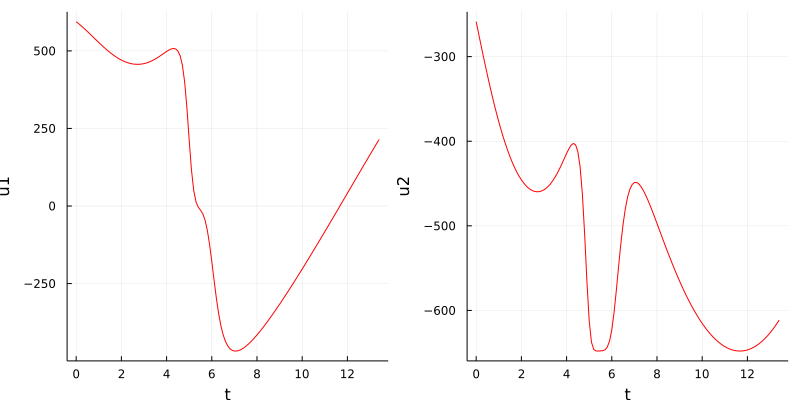

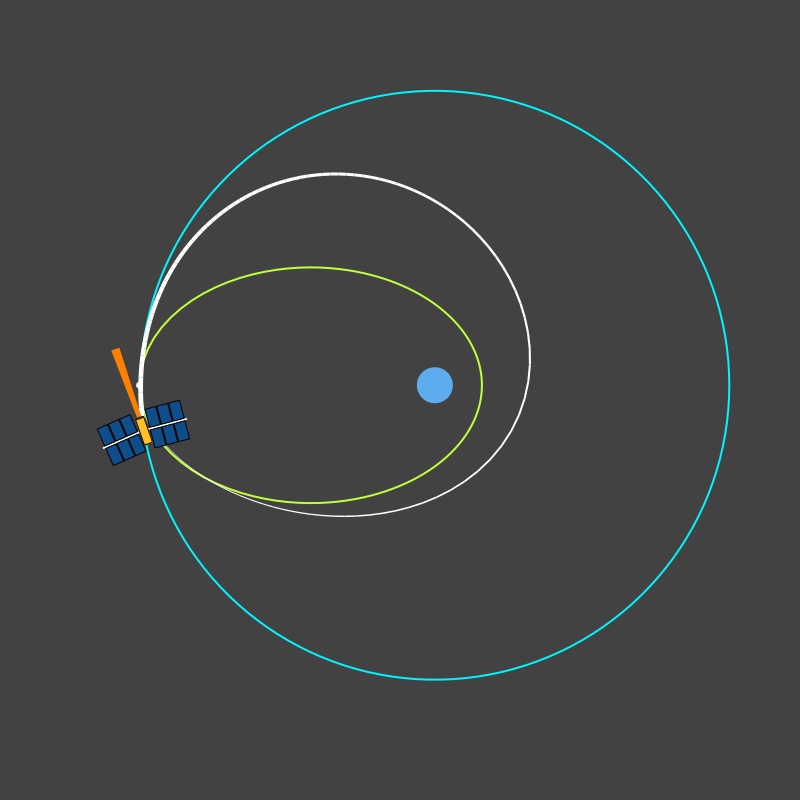

In [32]:
# On affiche la solution pour Fmax = 100
plot_solution(p0_sol_100, tf_sol_100)
# plot_solution(p0_sol_100, tf_sol_100; animation=true, fps=10, nFrame=200)       #Pour voir l'animation


# Etude du temps de transfert en fonction de la poussée maximale

<div class="alert alert-info">

**_Question 3:_**
    
* A l'aide de ce que vous avez fait précédemment, déterminer $t_f$ pour
    
$$
    F_\mathrm{max} \in \{100, 90, 80, 70, 60, 50, 40, 30, 20 \}.
$$
    
* Tracer ensuite $t_f$ en fonction de $F_\mathrm{max}$ et commenter le résultat.
      
</div>

In [33]:
# Les différentes valeurs de poussées
F_max_span = range(100, stop=20, length=11);
γ_max_span = [F_max_span[j]*3600^2/(2000*10^3) for j in 1:size(F_max_span,1)];

In [34]:
#####
##### A COMPLETER

# Solution calculée précédemment
y_guess = [p0_sol_100; [tf_sol_100]] 


tf_sols = zeros(length(γ_max_span))
p0_sols = zeros(4, length(γ_max_span))


for i in 1:length(γ_max_span)
    γ_max = γ_max_span[i];
    f = Flow(hv);
    
    # Jacobienne de la fonction de tir
    foo(y)  = shoot(y[1:4], y[5])
    jfoo(y) = ForwardDiff.jacobian(foo, y)

    # Résolution de shoot(p0, tf) = 0
    nl_sol = nlsolve(foo, jfoo, y_guess; xtol=1e-8, method=:trust_region, show_trace=false);

    # On récupère la solution si convergence
    if converged(nl_sol)
        p0_sols[:,i] = nl_sol.zero[1:4]
        tf_sols[i] = nl_sol.zero[5]
        y_guess = [p0_sols[:,i]; [tf_sols[i]]]
        println("\nFinal solution:\n", nl_sol.zero)
    else
        error("Not converged")
    end
end



Final solution:
[0.0001032311891361889, 4.8926427812361646e-5, 0.0003567967293906542, -0.0001553613886285987, 13.403181957149313]

Final solution:
[8.581713189736855e-5, 4.823434017280023e-5, 0.00035174966960542747, -0.00026556008360941797, 13.842412694293017]

Final solution:
[4.701018657472531e-5, 4.453506776935719e-5, 0.00032477266855123474, -0.0004884780851598338, 14.388112730599133]

Final solution:
[-8.975846492585536e-5, 2.578307233481674e-5, 0.00018802345264189743, -0.0012158766215542814, 15.168652689912884]

Final solution:
[-0.0005358485722273537, -3.773772826472043e-5, -0.00027520296538168285, -0.0035678596662532245, 16.787507855054404]

Final solution:
[-0.0005721785006617804, -3.227463722738696e-5, -0.00023536328973782286, -0.003833598690785723, 19.54830389394115]

Final solution:
[-0.0004898952365456491, -1.0804071086080495e-5, -7.878885502236823e-5, -0.003456893915711782, 22.741836800576564]

Final solution:
[-0.00012881729648273152, 2.805980107797503e-5, 0.000204626532

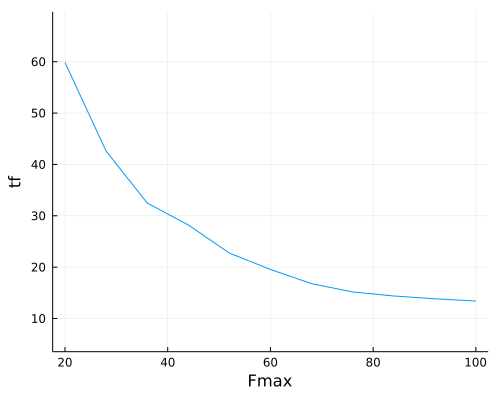

In [35]:
# Affichage de tf en fonction de la poussée maximale
plot(F_max_span, tf_sols, aspect_ratio=:equal, legend=false, xlabel="Fmax", ylabel="tf")

**Commentaire :**
D'après la figure ci-dessus, on peut bien voir que la courbe est décroissante : tf décroit quand on augmente Fmax.
Ceci est normal car plus la poussée Fmax est grande, plus le sattelite rejoint l'orbite plus rapidement, et donc il fera moins de temps à le rejoindre, d'où le temps final tf qui diminue en augmentant la pousséé. 

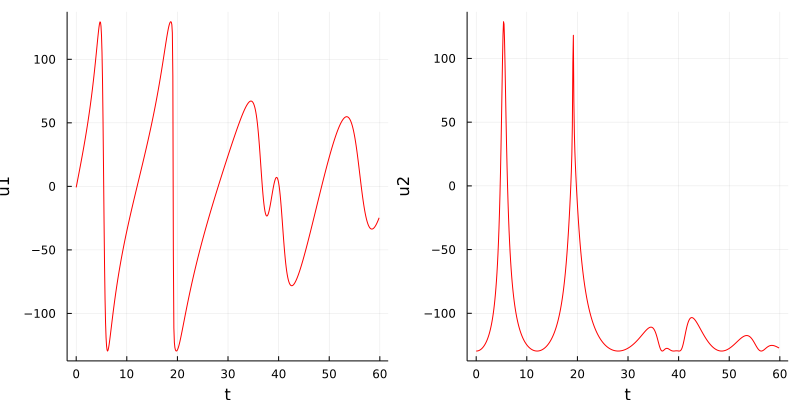

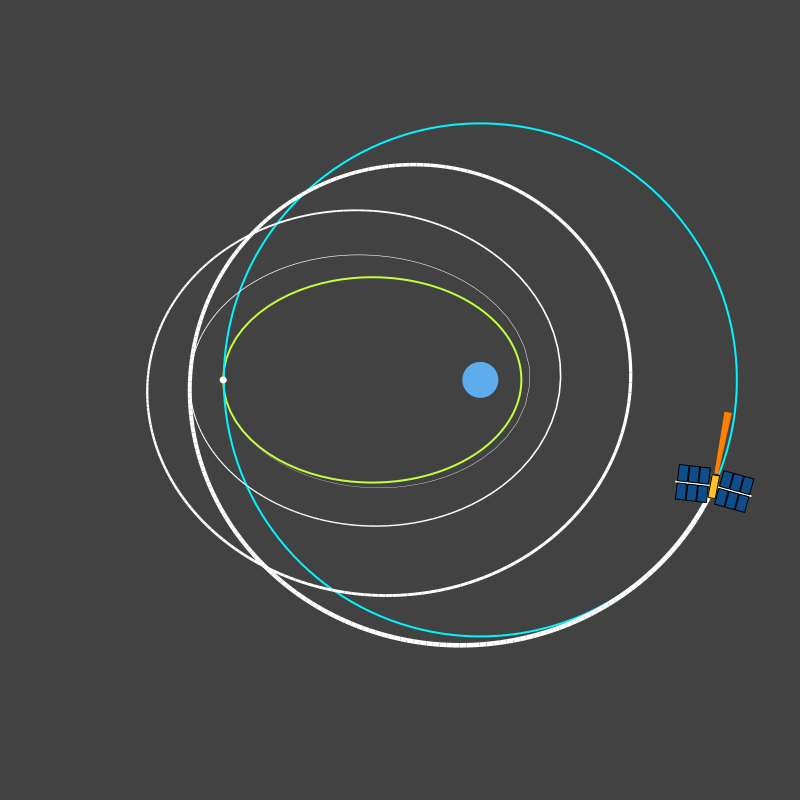

In [36]:
# Plots sol pour F_max = 20N
plot_solution(p0_sols[:, end], tf_sols[end])